**Updated**: 09.12.2021

In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import pyasn
import requests
from mpl_toolkits.basemap import Basemap
import time
import json

from colors import Colors

%matplotlib inline

In [2]:
connection = sq.connect("./performance-measurements/merged.db")
connection.row_factory = sq.Row
asndb = pyasn.pyasn('09-06-2021.dat')

In [3]:
vantage_points = {
                  'US East':                  {'short': 'us-east_', 'location': {'lat':  39.0437, 'lng': -77.4875}},
                  'Asia Pacific Northeast':   {'short': 'ap-northeast_', 'location': {'lat': 34.6937, 'lng': 135.5022}},
                  'Africa South':             {'short': 'af-south_', 'location': {'lat':  -33.9258, 'lng': 18.4232}},
                  'Europe Central':           {'short': 'eu-central_', 'location': {'lat': 50.1155, 'lng': 8.6842}},
                  'Asia Pacific Southeast':   {'short': 'ap-southeast_', 'location': {'lat': -33.8679, 'lng': 151.2073}},
                  'US West':                  {'short': 'us-west_', 'location': {'lat':  37.7749, 'lng': -122.4194}},
                  'South America East':       {'short': 'sa-east_', 'location': {'lat': -23.5475, 'lng': -46.6361}},
                  'All':                      {'short': '', 'location': {'lat': 0.0, 'lng': 0.0}}
                 }

In [3]:
def getRCodeCountForProtocol(protocol):
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming AND protocol = '{}'".format(protocol), connection)
    return df.groupby("r_code", as_index = True).size().reset_index(name = "count").set_index("r_code")

def getErrorSuccessCountForProtocol(protocol):
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE created < 1624485600 AND protocol = '{}' AND NOT cache_warming AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    success = (len(df.index) - df.isna().sum(axis = 0)).item()
    error = df.isna().sum(axis = 0).item()
    state = pd.DataFrame({ "status": ["success", "error", "error_rate"], "count": [(len(df.index) - df.isna().sum(axis = 0)).item(), df.isna().sum(axis = 0).item(), error / len(df.index)] })
    state = state.set_index("status")
    return state

def getErrorSuccessCountForQUIC():
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE created < 1624485600 AND protocol = 'quic' AND not cache_warming AND (ip, port) IN (SELECT ip, port FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL)", connection)
    state = pd.DataFrame({ "status": ["success", "error", "error_rate"], "count": [(len(df.index) - df.isna().sum(axis = 0)).item(), df.isna().sum(axis = 0).item(), df.isna().sum(axis = 0).item() / len(df.index)] })
    state = state.set_index("status")
    return state

def getHTTPVersion():
    df = pd.read_sql_query("SELECT http_version FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'https'", connection)
    return df.groupby("http_version").size().reset_index(name = "count").set_index("http_version")

def getTLSVersions(protocol):
    df = pd.read_sql_query("SELECT tls_version FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = '{}'".format(protocol), connection)
    return df.groupby("tls_version").size().reset_index(name = "count").set_index("tls_version")

def getDoQVersions():
    df = pd.read_sql_query("SELECT q_ui_c_negotiated_protocol AS quic_negotiated_protocol FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    return df.groupby("quic_negotiated_protocol").size().reset_index(name = "count").set_index("quic_negotiated_protocol")

def getQUICVersions():
    df = pd.read_sql_query("SELECT q_ui_c_version AS quic_version FROM dns_measurements WHERE q_ui_c_version IS NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    grouped_df = df.groupby("quic_version", as_index = False).size()
    def toText(row):
        if row["quic_version"] == 4278190109:
            return "Draft 29"
        elif row["quic_version"] == 4278190112:
            return "Draft 32"
        elif row["quic_version"] == 4278190114:
            return "Draft 34"
        else:
            return "Unknown"
    
    grouped_df["version_name"] = grouped_df.apply(toText, axis = 1)
    return grouped_df.set_index("quic_version")

def getDoQPortServers():
    df = pd.read_sql_query("SELECT DISTINCT ip, port FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    counter = {}
    for i, row in df.iterrows():
        if row["ip"] not in counter:
            counter[row["ip"]] = {}
        counter[row["ip"]][row["port"]] = True
    only784 = 0
    only8853 = 0
    both = 0
    for key, value in counter.items():
        if 784 in value and 8853 in value:
            both += 1
        elif 784 in value:
            only784 += 1
        elif 8853 in value:
            only8853 += 1
    return pd.DataFrame({ "Port": ["784", "8853", "both"], "Count": [only784, only8853, both] }).set_index("Port")

def getCountOfUsableMeasurementsForProtocol(protocol):
    df = pd.read_sql_query("SELECT COUNT(*) as count FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    return df["count"].values[0]

def getUsableMeasurements():
    count_udp = getCountOfUsableMeasurementsForProtocol("udp")
    return pd.DataFrame({ "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"], "Count": [
        getCountOfUsableMeasurementsForProtocol("udp"),
        getCountOfUsableMeasurementsForProtocol("tcp"),
        getCountOfUsableMeasurementsForProtocol("tls"),
        getCountOfUsableMeasurementsForProtocol("https"),
        getCountOfUsableMeasurementsForProtocol("quic")
    ] }).set_index("Protocol")

def categorizeErrors(errors):
    result = Counter()
    for _, row in errors.iterrows():
        if "i/o timeout" in row["error"]:
            result["timeout"] += 1
        elif "connection refused" in row["error"]:
            result["connection_refused"] += 1
        elif "no route to host" in row["error"]:
            result["no_route"] += 1
        elif "overflow unpacking uint16" in row["error"]:
            result["overflow"] += 1
        elif "EOF" in row["error"]:
            result["eof"] += 1
        elif "unrecognized name" in row["error"]:
            result["unrecognized_name"] += 1
        elif "request canceled" in row["error"]:
            result["request_canceled"] += 1
        elif "context deadline exceeded" in row["error"]:
            result["timeout"] += 1
        elif "tls: internal error" in row["error"]:
            result["tls_internal_error"] += 1
        elif "tls: handshake failure" in row["error"]:
            result["tls_handshake_failure"] += 1 
        elif "stopped after" in row["error"]:
            result["too_many_redirect"] += 1
        elif "bad rdata" in row["error"]:
            result["bad_rdata"] += 1
        elif "stream error" in row["error"]:
            result["stream_error"] += 1
        elif "connection reset by peer" in row["error"]:
            result["connection_reset"] += 1
        elif "server gave HTTP response to HTTPS client" in row["error"]:
            result["http_response"] += 1
        elif "network is unreachable" in row["error"]:
            result["network_unreachable"] += 1
        else:
            print(row["error"])
    return pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'error', 0:'count'}).set_index("error")

def categorizeQUICErrors(errors):
    result = Counter()
    for _, row in errors.iterrows():
        if "No recent network activity" in row["error"]:
            result["timeout"] += 1
        elif "tls: internal error" in row["error"]:
            result["tls_internal_error"] += 1
        else:
            print(row["error"])
    return pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'error', 0:'count'}).set_index("error")
        
def getTotalErrorsCategorized(protocol):
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND error IS NOT NULL".format(protocol), connection)
    return categorizeErrors(udp_errors)

def getErrorsCategorized(protocol):
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE created < 1624485600 AND protocol = '{}' AND NOT cache_warming AND error IS NOT NULL AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    return categorizeErrors(udp_errors)

def getQUICTotalErrorsCategorized():
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = 'quic' AND NOT cache_warming AND error IS NOT NULL AND r_code IS NULL", connection)
    return categorizeQUICErrors(udp_errors)

def getQUICErrorsCategorized():
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE created < 1624485600 AND protocol = 'quic' AND error IS NOT NULL AND r_code IS NULL AND not cache_warming AND (ip, port) IN (SELECT ip, port FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL)", connection)
    return categorizeQUICErrors(udp_errors)

def getASN():
    def lookupAPI(row):
        r = requests.get("http://api.asrank.caida.org/v2/restful/asns/" + str(row["ASN"]))
        json = r.json()
        return json["data"]["asn"]["asnName"]
    df = pd.read_sql_query("SELECT DISTINCT ip FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL", connection)
    df["ASN"] = df.apply(lambda row: asndb.lookup(row["ip"])[0], axis = 1)
    grouped_df = df.groupby("ASN", as_index = False).size()
    largest = grouped_df.nlargest(10, "size")
    largest["ASN Name"] = largest.apply(lookupAPI, axis = 1)
    return largest

In [20]:
def getIPs(protocol):
    sql = f"""
    SELECT DISTINCT ip FROM dns_measurements_clean WHERE protocol = '{protocol}'
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items


ips = getIPs('quic')

data = {}
try:
    df = pd.read_csv("ip-location.csv")
    for index, row in df.iterrows():
        data[row["ip"]] = row
except:
    pass
for row in ips:
    if row["ip"] in data:
        continue
    r = requests.get("http://ip-api.com/json/" + row["ip"])
    json = r.json()
    data[row["ip"]] = {
        "country": json["country"],
        "countryCode": json["countryCode"],
        "region": json["region"],
        "regionName": json["regionName"],
        "city": json["city"],
        "zip": json["zip"],
        "lat": json["lat"],
        "lon": json["lon"],
        "org": json["org"],
        "as": json["as"],
        "ip": row["ip"]
    }
    time.sleep(2)
df_all_doq = pd.DataFrame.from_dict(data, orient = "index")
df_all_doq.to_csv("ip-location.csv", index = False)

def drawAllDoQResolver():
    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(df_all_doq["lon"].tolist(), df_all_doq["lat"].tolist())
    homeX, homeY = worldMap([11.66864063068705], [48.26187023547006])
    plt.plot(x, y, 'bo', color = 'r', markersize = 3)
    plt.plot(homeX, homeY, 'bo', color = 'b', markersize = 5)
    plt.savefig("figures/all_doq_resolvers.pdf", bbox_inches='tight')
    plt.show()

In [48]:
def drawAllForProtocol(protocol, vp_key='All'):
    vp=vantage_points[vp_key]['short']
    df = pd.read_sql_query("SELECT * FROM dns_measurements_clean WHERE protocol = '{}' AND id LIKE '{}%' AND NOT cache_warming".format(protocol, vp), connection)

    ips = df["ip"].unique()
    locations = []
    for ip in ips:
        if ip in data:
            locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })

    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'ro', markersize = 3)
    if vp_key != 'All':
        vp_loc = vantage_points[vp_key]['location']
        homeX, homeY = worldMap([vp_loc['lng']], [vp_loc['lat']])
        plt.plot(homeX, homeY, 'bo', markersize = 5)
    plt.savefig("figures/{}map_all_{}.pdf".format(vp, protocol), bbox_inches='tight')
    plt.show()

    
def drawFastestForQUIC(vp_key='All', slowest=False):
    vp=vantage_points[vp_key]['short']
    # First get IP addresses that are reachable with every protocol
    sql = f"""
    SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND NOT cache_warming AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'quic') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'udp') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'tls') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'https') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'tcp');
    """
    df_all = pd.read_sql_query(sql, connection)
    all_ips = df_all["ip"].tolist()
    # Next get all quic IPs and sort them
    df = pd.read_sql_query(f"SELECT * FROM dns_measurements_clean WHERE protocol = 'quic' AND id LIKE '{vp}%' AND NOT cache_warming", connection)
    grouped_df = df.groupby("ip")
    mean_df = grouped_df["total_time"].mean()
    mean_df = mean_df.reset_index()
    
    if slowest:
        largest = mean_df.nlargest(20, "total_time")
    else:
        largest = mean_df.nsmallest(20, "total_time")

    # Check for each quic IP if it is in the all_ips list, if so add it to the results
    ips = largest["ip"].tolist()
    locations = []
    for ip in ips:
        if ip in all_ips:
            if ip in data:
                locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })
                
    # draw the figure
    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'ro', markersize = 3)
    if vp_key != 'All':
        vp_loc = vantage_points[vp_key]['location']
        homeX, homeY = worldMap([vp_loc['lng']], [vp_loc['lat']])
        plt.plot(homeX, homeY, 'bo', markersize = 5)
    if slowest:
        plt.savefig("figures/{}map_slowest_quic.pdf".format(vp), bbox_inches='tight')
    else:
        plt.savefig("figures/{}map_fastest_quic.pdf".format(vp), bbox_inches='tight')
    plt.show()   
    
    
def drawOrderedForQUIC(vp_key='All', slowest=False):
    vp=vantage_points[vp_key]['short']
    # First get IP addresses that are reachable with every protocol
    sql = f"""
    SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND NOT cache_warming AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'quic') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'udp') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'tls') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'https') AND
    ip IN (SELECT DISTINCT ip FROM dns_measurements_clean WHERE id LIKE '{vp}%' AND protocol = 'tcp');
    """
    df_all = pd.read_sql_query(sql, connection)
    all_ips = df_all["ip"].tolist()
    # Next get all quic IPs and sort them
    df = pd.read_sql_query(f"SELECT * FROM dns_measurements_clean WHERE protocol = 'quic' AND id LIKE '{vp}%' AND NOT cache_warming", connection)
    grouped_df = df.groupby("ip")
    mean_df = grouped_df["total_time"].mean()
    mean_df = mean_df.reset_index()
    
    if slowest:
        largest = mean_df.sort_values("total_time", ascending=False)
    else:
        largest = mean_df.sort_values("total_time")

    # Check for each quic IP if it is in the all_ips list, if so add it to the results
    ips = largest["ip"].tolist()
    ases = []
    locations = []
    for ip in ips:
        if ip in all_ips:
            if ip in data:
                this_as = data[ip]['as']
                if this_as not in ases:
                    print(ip)
                    ases.append(this_as)
                locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })
                
    # draw the figure
    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'ro', markersize = 3)
    if vp_key != 'All':
        vp_loc = vantage_points[vp_key]['location']
        homeX, homeY = worldMap([vp_loc['lng']], [vp_loc['lat']])
        plt.plot(homeX, homeY, 'bo', markersize = 5)
    if slowest:
        plt.savefig("figures/{}map_all_quic.pdf".format(vp), bbox_inches='tight')
    else:
        plt.savefig("figures/{}map_all_quic.pdf".format(vp), bbox_inches='tight')
    plt.show()

### Fastest QUIC Resolvers (that support all protocols)

US East
34.86.106.186
150.136.110.156
147.182.175.157
69.251.252.106
94.140.14.140
23.95.234.3
176.103.130.131
50.116.59.251
192.34.80.185
64.112.126.239
66.181.42.75
172.86.125.249
65.49.194.95
18.236.176.82
198.255.103.36
45.61.53.161
45.155.39.173
185.121.25.64
5.135.233.74
51.15.75.165
154.49.211.118
45.82.178.72
103.232.207.2
188.68.59.46
161.97.79.138
198.211.40.216
185.238.248.204
195.90.213.140
82.165.23.176
47.254.64.251
67.198.131.72
185.200.34.171
52.233.72.204
85.214.195.112
82.165.182.221
109.235.67.52
178.18.54.141
92.53.83.142
98.154.23.186
185.104.249.220
62.109.28.53
188.72.209.168
5.1.84.150
188.62.122.218
37.114.32.44
199.247.17.85
185.94.252.7
185.175.57.120
45.142.215.122
46.229.214.81
160.251.96.67
202.218.2.19
89.40.142.170
218.251.80.123
185.198.120.247
78.15.98.77
116.80.43.177
119.3.92.152
101.132.168.152
193.201.126.42
134.0.115.245
113.31.103.21
35.220.206.179
37.235.49.163
83.212.102.207
45.129.2.32
154.23.177.82
114.115.147.107
101.32.27.77
209.17.118.5
82

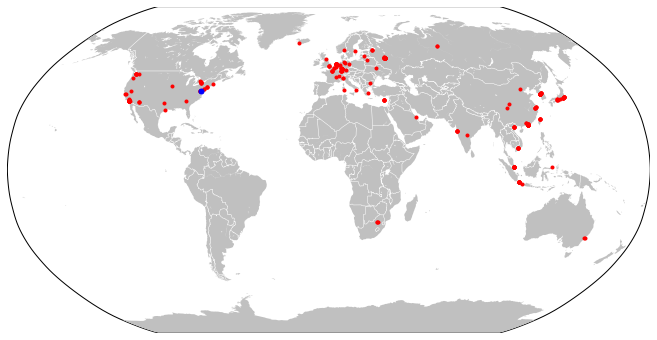

Asia Pacific Northeast
202.218.2.19
152.69.204.173
218.251.80.123
45.78.53.214
116.80.43.177
160.251.96.67
41.216.180.37
172.105.222.217
40.74.71.254
13.124.90.41
121.170.60.153
45.141.138.66
34.96.142.40
8.210.148.24
35.220.206.179
154.23.177.82
101.32.27.77
94.140.14.140
157.245.202.244
118.163.170.2
113.31.103.21
209.17.118.5
51.79.159.77
193.110.201.61
114.115.147.107
103.200.112.33
210.16.120.48
47.103.26.225
103.27.62.211
123.195.161.145
159.117.87.167
223.18.82.10
103.123.108.197
103.155.251.244
103.105.98.141
103.138.41.195
103.214.112.75
103.172.17.225
103.227.252.185
116.118.44.237
139.159.143.70
103.124.95.99
103.153.73.188
202.83.122.170
103.237.147.61
198.211.54.194
123.30.234.76
50.214.51.92
198.255.103.36
45.61.53.161
185.200.34.171
182.234.39.52
23.94.211.209
42.192.89.119
185.177.218.107
64.112.126.239
112.213.39.133
104.33.178.84
92.53.83.142
185.104.249.220
178.18.54.141
195.90.213.140
154.49.211.118
51.158.105.226
82.165.182.221
67.198.131.72
176.103.130.131
217.160

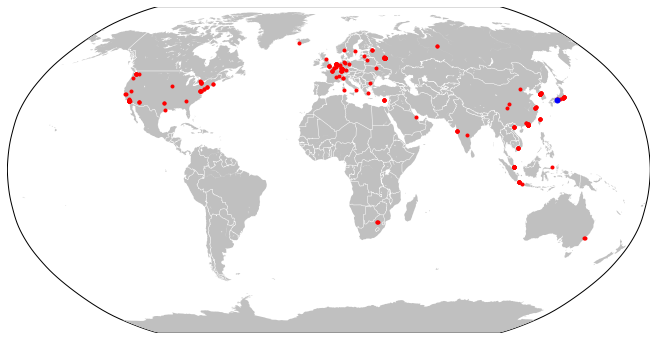

Africa South
41.21.230.0
154.0.173.6
45.155.39.173
185.121.25.64
18.135.203.88
87.98.165.2
178.62.213.209
23.94.120.177
51.15.75.165
152.70.61.147
45.82.178.72
85.214.195.112
82.165.23.176
154.49.211.118
188.68.59.46
178.18.54.141
82.165.182.221
195.90.213.140
161.97.79.138
104.199.26.56
109.235.67.52
94.140.15.16
92.53.83.142
185.104.249.220
94.250.249.194
91.239.27.199
188.72.209.168
139.162.142.149
5.1.84.150
69.251.252.106
20.52.130.183
199.247.17.85
78.15.98.77
185.94.252.7
188.62.122.218
64.112.126.239
185.175.57.120
45.142.215.122
37.114.32.44
86.107.110.135
37.235.49.163
45.61.53.161
172.86.125.249
89.208.251.213
198.255.103.36
193.201.126.42
194.87.236.82
134.0.115.245
45.129.2.32
82.118.227.235
185.198.120.247
46.229.214.81
38.242.12.100
154.23.177.82
209.17.118.5
83.212.102.207
114.115.147.107
192.34.80.185
47.109.80.110
103.155.251.244
101.32.27.77
185.177.218.107
8.210.148.24
113.31.103.21
161.129.152.196
66.181.42.75
160.251.96.67
198.211.40.216
139.159.143.70
185.238.248

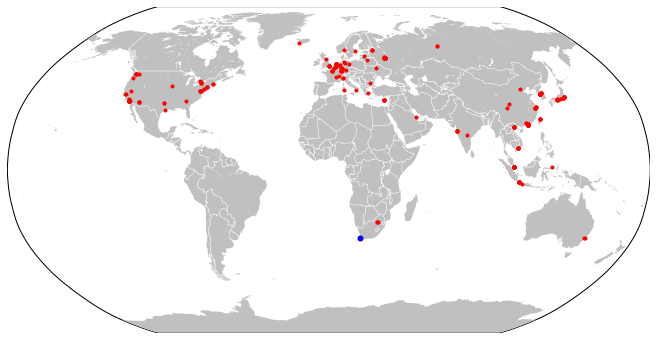

Europe Central
94.140.14.14
35.156.129.204
130.61.15.226
5.1.84.150
82.165.23.176
188.68.59.46
20.52.130.183
178.62.213.209
161.97.79.138
82.165.167.96
23.94.120.177
51.15.75.165
45.82.178.72
195.90.213.140
104.199.26.56
5.135.233.74
185.121.25.64
85.214.195.112
154.49.211.118
45.155.39.173
86.107.110.135
199.247.17.85
37.114.32.44
188.62.122.218
178.18.54.141
109.235.67.52
185.94.252.7
92.53.83.142
194.177.23.120
62.109.28.53
185.175.57.120
185.198.120.247
185.104.249.220
82.118.227.235
45.142.215.122
45.129.2.32
134.0.115.245
193.201.126.42
194.87.236.82
78.15.98.77
37.235.49.163
83.212.102.207
46.229.214.81
69.251.252.106
64.112.126.239
38.242.12.100
50.116.59.251
192.34.80.185
45.61.53.161
185.177.218.107
172.86.125.249
65.49.194.95
114.115.147.107
209.17.118.5
198.255.103.36
66.181.42.75
161.129.152.196
113.31.103.21
47.109.80.110
154.23.177.82
8.210.148.24
45.124.65.250
103.232.207.3
198.211.40.216
103.123.108.197
67.198.131.72
185.200.34.171
160.251.96.67
98.154.23.186
35.220.20

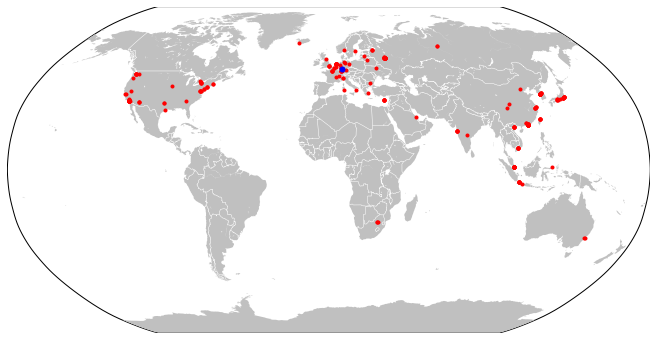

Asia Pacific Southeast
139.99.239.191
94.140.14.140
112.213.39.133
157.245.202.244
209.17.118.5
140.238.36.23
160.251.96.67
202.218.2.19
40.74.71.254
218.251.80.123
45.78.53.214
116.80.43.177
8.210.148.24
34.96.142.40
101.32.27.77
103.123.108.197
35.220.206.179
18.236.176.82
23.94.211.209
154.23.177.82
172.86.125.249
103.27.62.211
45.61.53.161
210.16.120.48
198.255.103.36
103.155.251.244
103.172.17.225
172.105.222.217
103.214.112.75
103.138.41.195
103.105.98.141
103.227.252.185
193.110.201.61
14.225.254.221
103.161.172.14
223.18.82.10
103.107.182.7
41.216.180.37
64.112.126.239
202.83.122.170
69.251.252.106
67.198.131.72
103.124.95.99
121.170.60.153
103.200.112.33
45.141.138.66
103.237.147.61
198.211.54.194
118.163.170.2
119.3.92.152
185.200.34.171
98.154.23.186
103.232.207.2
47.106.85.147
176.103.130.137
178.18.54.141
185.121.25.64
182.234.39.52
51.15.75.165
195.90.213.140
66.181.42.75
154.49.211.118
159.117.87.167
161.129.152.196
113.31.103.21
82.165.23.176
109.235.67.52
188.68.59.46


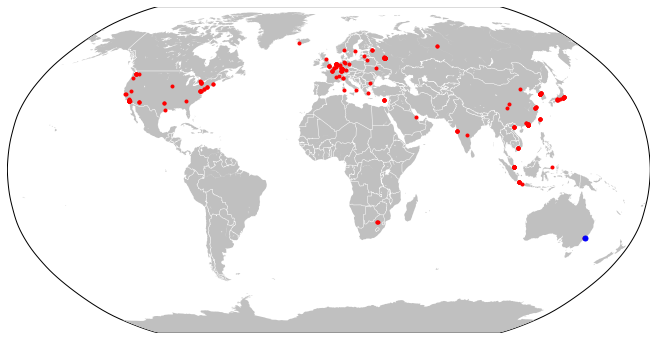

US West
173.230.153.18
47.254.64.251
45.61.53.161
94.140.15.15
172.86.125.249
199.115.228.98
198.211.54.194
198.255.103.36
185.238.248.204
67.198.131.72
185.200.34.171
18.236.176.82
23.94.211.209
129.146.170.128
103.232.207.3
98.154.23.186
52.233.72.204
64.112.126.239
50.214.51.92
34.121.75.184
66.181.42.75
176.103.130.131
161.129.152.196
147.182.175.157
160.251.96.67
38.242.12.100
218.251.80.123
192.34.80.185
202.218.2.19
119.3.92.152
113.31.103.21
45.155.39.173
185.121.25.64
5.135.233.74
51.15.75.165
45.124.65.250
47.100.207.231
101.32.27.77
45.82.178.72
154.23.177.82
178.18.54.141
154.49.211.118
85.214.195.112
35.220.206.179
82.165.182.221
82.165.23.176
188.68.59.46
161.97.79.138
195.90.213.140
62.109.28.53
109.235.67.52
209.17.118.5
46.161.54.34
114.115.147.107
116.80.43.177
103.123.108.197
121.170.60.153
185.104.249.220
42.192.89.119
185.94.252.7
45.141.138.66
188.72.209.168
118.163.170.2
188.62.122.218
78.15.98.77
199.247.17.85
103.135.251.242
37.114.32.44
112.213.39.133
103.200.

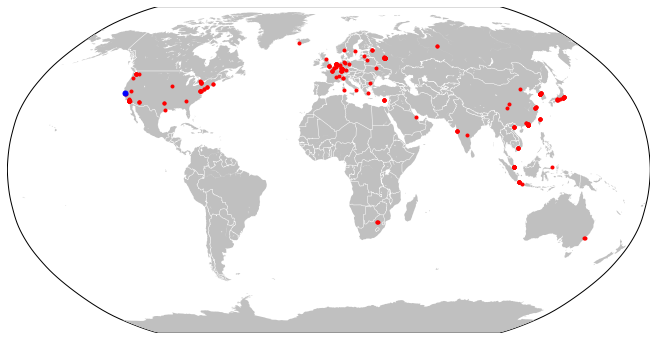

South America East
147.182.175.157
158.101.98.125
94.140.14.15
23.95.234.3
69.251.252.106
34.121.75.184
176.103.130.137
64.112.126.239
50.116.59.251
172.86.125.249
198.255.103.36
65.49.194.95
18.236.176.82
38.242.12.100
45.155.39.173
45.61.53.161
51.15.75.165
5.135.233.74
154.49.211.118
192.34.80.185
188.68.59.46
185.121.25.64
45.82.178.72
82.165.23.176
161.129.152.196
82.165.182.221
195.90.213.140
66.181.42.75
161.97.79.138
85.214.195.112
178.18.54.141
109.235.67.52
185.104.249.220
94.250.249.194
92.53.83.142
103.232.207.2
67.198.131.72
198.211.54.194
185.238.248.204
185.200.34.171
47.254.64.251
40.74.71.254
160.251.96.67
218.251.80.123
188.72.209.168
78.15.98.77
37.114.32.44
104.33.178.84
199.247.17.85
202.218.2.19
188.62.122.218
35.220.206.179
89.40.142.170
185.175.57.120
45.142.215.122
5.1.84.150
185.94.252.7
119.3.92.152
101.32.27.77
154.23.177.82
113.31.103.21
114.115.147.107
185.198.120.247
45.129.2.32
101.132.168.152
82.118.227.235
37.235.49.163
83.212.102.207
209.17.118.5
46.2

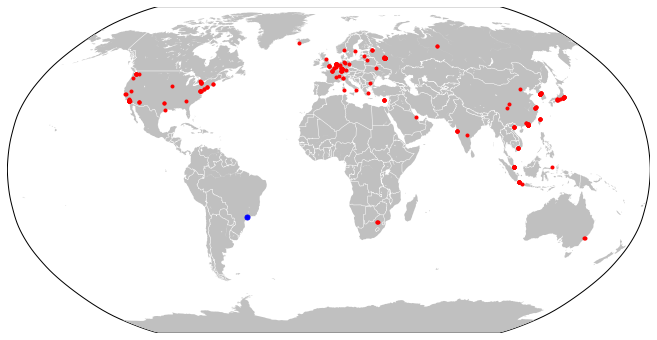

All
94.140.14.140
193.123.247.107
147.182.175.157
34.121.75.184
18.236.176.82
23.95.234.3
45.61.53.161
64.112.126.239
176.103.130.131
198.255.103.36
69.251.252.106
45.155.39.173
185.121.25.64
51.15.75.165
5.135.233.74
172.86.125.249
154.49.211.118
65.49.194.95
178.18.54.141
195.90.213.140
188.68.59.46
82.165.23.176
82.165.182.221
45.82.178.72
85.214.195.112
161.97.79.138
109.235.67.52
40.74.71.254
160.251.96.67
92.53.83.142
185.104.249.220
218.251.80.123
47.254.64.251
94.250.249.194
50.116.59.251
198.211.54.194
202.218.2.19
154.23.177.82
209.17.118.5
101.32.27.77
192.34.80.185
38.242.12.100
185.200.34.171
66.181.42.75
67.198.131.72
161.129.152.196
116.80.43.177
35.220.206.179
103.232.207.3
113.31.103.21
185.238.248.204
98.154.23.186
103.136.18.163
188.72.209.168
114.115.147.107
78.15.98.77
37.114.32.44
185.94.252.7
188.62.122.218
5.1.84.150
103.123.108.197
89.40.142.170
119.3.92.152
199.247.17.85
185.175.57.120
47.100.207.231
45.142.215.122
185.198.120.247
45.141.138.66
134.0.115.245
4

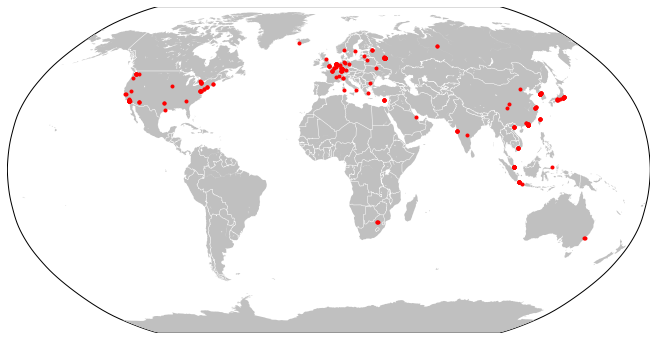

In [49]:
for key, vp in vantage_points.items():
    print(key)
    drawOrderedForQUIC(key)

## General Data

In [13]:
df_general = pd.read_sql_query("SELECT COUNT(*) as total_measurements FROM dns_measurements WHERE NOT cache_warming", connection)
print(df_general.to_markdown())

|    |   total_measurements |
|---:|---------------------:|
|  0 |          1.14963e+06 |


#### Total Measurements per Protocol

In [14]:
measurements_per_protocol = pd.read_sql_query("SELECT protocol, COUNT(*) as count FROM dns_measurements WHERE NOT cache_warming GROUP BY protocol", connection)
print(measurements_per_protocol.set_index("protocol").to_markdown())

| protocol   |   count |
|:-----------|--------:|
| https      |  191495 |
| quic       |  381797 |
| tcp        |  192125 |
| tls        |  191825 |
| udp        |  192389 |


#### Usable Measurements per Protocol

- All the measurements of resolvers which have at least one successful response
- success = response with a r_code
- error = response without a r_code

In [15]:
print(getUsableMeasurements().to_markdown())

| Protocol   |   Count |
|:-----------|--------:|
| UDP        |   86066 |
| TCP        |   86786 |
| TLS        |  155300 |
| HTTPS      |   96408 |
| QUIC       |  379983 |


#### Total Number of Response Codes across Protocols

In [16]:
df_general = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming", connection)
df_general = df_general.groupby("r_code", as_index = True).size().reset_index(name = "count").set_index("r_code")
print(df_general.to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  477326 |
|        2 |    2224 |
|        3 |    6891 |
|        5 |    8204 |


#### Number of Servers per Protocol

In [17]:
df = pd.read_sql_query("SELECT DISTINCT(ip), protocol FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming", connection)
df = df.groupby("protocol").size().reset_index(name = "count").set_index("protocol")
print(df.to_markdown())

| protocol   |   count |
|:-----------|--------:|
| https      |     436 |
| quic       |     862 |
| tcp        |     391 |
| tls        |     701 |
| udp        |     389 |


<br>
<br>
<br>
<br>

## QUIC

In [18]:
print(getRCodeCountForProtocol("quic").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  159500 |
|        2 |     791 |
|        3 |    1573 |
|        5 |    1331 |


In [178]:
print(getErrorSuccessCountForQUIC().to_markdown())

| status     |         count |
|:-----------|--------------:|
| success    | 23279         |
| error      |  1050         |
| error_rate |     0.0431584 |


#### All errors

In [20]:
print(getQUICTotalErrorsCategorized().to_markdown())

| error              |   count |
|:-------------------|--------:|
| timeout            |  218523 |
| tls_internal_error |      79 |


#### Errors for Successful Servers

In [21]:
print(getQUICErrorsCategorized().to_markdown())

| error   |   count |
|:--------|--------:|
| timeout |    1050 |


#### DoQ Versions

In [22]:
print(getDoQVersions().to_markdown())

| quic_negotiated_protocol   |   count |
|:---------------------------|--------:|
| doq-i00                    |   21335 |
| doq-i02                    |  141860 |


#### QUIC Versions

In [23]:
print(getQUICVersions().to_markdown())

|   quic_version |   size | version_name   |
|---------------:|-------:|:---------------|
|     4278190109 | 112302 | Draft 29       |
|     4278190112 |  12295 | Draft 32       |
|     4278190114 |  38599 | Draft 34       |


#### DOQ Ports

In [24]:
print(getDoQPortServers().to_markdown())

| Port   |   Count |
|:-------|--------:|
| 784    |     680 |
| 8853   |     169 |
| both   |      13 |


#### 0-RTT

No servers were found with support for QUIC 0-RTT

<br>
<br>
<br>
<br>

#### All DoQ Resolvers

In [ ]:
drawAllDoQResolver()

In [10]:
countriesContinents = pd.read_csv("Countries-Continents.csv", index_col = False)
renamed = countriesContinents.columns.tolist()
renamed[0] = "country"
countriesContinents.columns = renamed
byCountry = df_all_doq.groupby("country").size().reset_index(name = "size").sort_values("size", ascending = False)
withContinent = pd.merge(byCountry, countriesContinents, on = "country")
withContinent.groupby(["region"]).sum("size").reset_index()[["region", "size"]]

,region,size
0,Africa,7
1,Americas,202
2,Asia,419
3,Europe,253
4,Oceania,23


## ASN

In [28]:
getASN()

,ASN,size,ASN Name
104,31898,48,ORACLE-BMC-31898
119,37963,46,CNNIC-ALIBABA-CN-NET-AP
79,20473,37,AS-CHOOPA
135,42473,34,AS-ANEXIA
142,45090,33,CNNIC-TENCENT-NET-AP
202,132203,28,TENCENT-NET-AP-CN
64,16276,27,OVH
57,14061,25,DIGITALOCEAN-ASN
116,36352,21,AS-COLOCROSSING
59,15169,20,GOOGLE


In [16]:
print(data['132.145.167.127']['as'])

AS31898 Oracle Corporation


<br>
<br>
<br>
<br>

## UDP

In [34]:
print(getRCodeCountForProtocol("udp").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   59632 |
|        2 |     363 |
|        3 |    1091 |
|        5 |    1885 |


In [35]:
print(getErrorSuccessCountForProtocol("udp").to_markdown())

| status     |      count |
|:-----------|-----------:|
| success    | 9366       |
| error      | 1493       |
| error_rate |    0.13749 |


#### All errors

In [36]:
print(getTotalErrorsCategorized("udp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |   16907 |
| timeout            |  111958 |
| no_route           |     536 |
| overflow           |      17 |


#### Errors for Successful Servers

In [37]:
print(getErrorsCategorized("udp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     222 |
| timeout            |    1263 |
| no_route           |       3 |
| overflow           |       5 |


<br>
<br>
<br>
<br>

## TCP

In [62]:
print(getRCodeCountForProtocol("tcp").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   59919 |
|        2 |     343 |
|        3 |    1101 |
|        5 |    3037 |


In [63]:
print(getErrorSuccessCountForProtocol("tcp").to_markdown())

| status     |       count |
|:-----------|------------:|
| success    | 9366        |
| error      | 1566        |
| error_rate |    0.143249 |


#### All errors

In [71]:
print(getTotalErrorsCategorized("tcp").to_markdown())

| error               |   count |
|:--------------------|--------:|
| connection_refused  |   19881 |
| timeout             |  106546 |
| eof                 |     510 |
| no_route            |     784 |
| network_unreachable |       2 |
| connection_reset    |       2 |


#### Errors for Successful Servers

In [64]:
print(getErrorsCategorized("tcp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     253 |
| timeout            |    1305 |
| no_route           |       8 |


#### TCP Fast Open (TFO)

No servers were found with support for TFO

#### edns-tcp-keepalive

12 resolvers were found to support edns-tcp-keepalive. They are all part of the AdGuard Organization. The timeout value returned for all of them is 0 meaning to close the connection after having received the response.

<br>
<br>
<br>
<br>

## TLS

In [42]:
print(getRCodeCountForProtocol("tls").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  118487 |
|        2 |     393 |
|        3 |    1571 |
|        5 |    1241 |


In [91]:
print(getErrorSuccessCountForProtocol("tls").to_markdown())

| status     |        count |
|:-----------|-------------:|
| success    | 17224        |
| error      |  2357        |
| error_rate |     0.120372 |


#### All errors

In [97]:
print(getTotalErrorsCategorized("tls").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |   12137 |
| timeout            |   56516 |
| unrecognized_name  |     222 |
| no_route           |     987 |
| tls_internal_error |     253 |
| eof                |      16 |
| connection_reset   |       2 |


#### Errors for Successful Servers

In [92]:
print(getErrorsCategorized("tls").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     149 |
| timeout            |    2198 |
| no_route           |      10 |


#### TLS Versions

In [46]:
print(getTLSVersions("tls").to_markdown())

|   tls_version |   count |
|--------------:|--------:|
|           772 |  121692 |


In [4]:
certs = pd.read_csv("certs.csv", converters={"info":json.loads}, header = None, names = ["ip", "protocol", "port", "info"])
certs["version"] = certs.apply(lambda row: row["info"]["Version"], axis = 1)
certs["public_key_algorithm"] = certs.apply(lambda row: row["info"]["PublicKeyAlgorithm"], axis = 1)
certs["signature_key_algorithm"] = certs.apply(lambda row: row["info"]["SignatureAlgorithm"], axis = 1)
certs["size"] = certs.apply(lambda row: row["info"]["Size"], axis = 1)

In [116]:
certs_tls = certs[certs["protocol"] == "tls"]

In [122]:
certs_tls.groupby("version").size().reset_index(name = "count")

,version,count
0,1,1
1,3,699


In [120]:
certs_tls.groupby("public_key_algorithm").size().reset_index(name = "count")

,public_key_algorithm,count
0,ECDSA,234
1,RSA,466


In [121]:
certs_tls.groupby("signature_key_algorithm").size().reset_index(name = "count")

,signature_key_algorithm,count
0,ECDSA-SHA256,10
1,ECDSA-SHA384,22
2,SHA1-RSA,3
3,SHA256-RSA,655
4,SHA384-RSA,9
5,SHA512-RSA,1


In [9]:
def build(df, dictKey = "signature_key_algorithm"):
    result = {}
    for key in df[dictKey].unique():
        result[key] = df[df[dictKey] == key]["size"].tolist()
    return pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in result.items() ]))

In [18]:
ax = build(certs_tls, "public_key_algorithm").plot.hist(bins = 100, figsize = (10, 7), alpha = 0.7)
plt.grid()
ax.set_xlabel("bytes")
plt.savefig("figures/tls_cert_sizes.pdf", bbox_inches='tight')

NameError: name 'certs_tls' is not defined

## QUIC

In [5]:
certs_quic = certs[certs["protocol"] == "quic"]

In [17]:
certs_quic.groupby("version").size().reset_index(name = "count")

,version,count
0,1,2
1,3,760


In [11]:
pub_key = certs_quic.groupby("public_key_algorithm").size().reset_index(name = "count")
pub_key["percentage"] = pub_key["count"] / pub_key["count"].sum()
pub_key

,public_key_algorithm,count,percentage
0,ECDSA,252,0.330709
1,RSA,510,0.669291


In [16]:
sign_key = certs_quic.groupby("signature_key_algorithm").size().reset_index(name = "count")
sign_key["percentage"] = sign_key["count"] / sign_key["count"].sum()
sign_key.sort_values("count", ascending = False)

,signature_key_algorithm,count,percentage
3,SHA256-RSA,701,0.919948
1,ECDSA-SHA384,34,0.044619
0,ECDSA-SHA256,12,0.015748
4,SHA384-RSA,11,0.014436
2,SHA1-RSA,3,0.003937
5,SHA512-RSA,1,0.001312


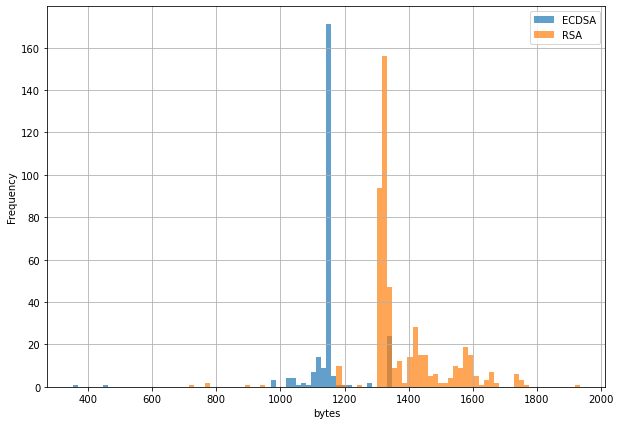

In [20]:
ax = build(certs_quic, "public_key_algorithm").plot.hist(bins = 100, figsize = (10, 7), alpha = 0.7)
plt.grid()
ax.set_xlabel("bytes")
plt.savefig("figures/quic_cert_sizes.pdf", bbox_inches='tight')

<br>
<br>
<br>
<br>

## HTTPS

In [47]:
print(getRCodeCountForProtocol("https").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   79788 |
|        2 |     334 |
|        3 |    1555 |
|        5 |     710 |


In [175]:
print(getErrorSuccessCountForProtocol("https").to_markdown())

| status     |         count |
|:-----------|--------------:|
| success    | 11328         |
| error      |   826         |
| error_rate |     0.0679612 |


#### All errors

In [49]:
print(getTotalErrorsCategorized("https").to_markdown())

| error                 |   count |
|:----------------------|--------:|
| connection_refused    |   17353 |
| request_canceled      |   26320 |
| timeout               |    4578 |
| overflow              |   14492 |
| eof                   |    1637 |
| tls_internal_error    |    3633 |
| stream_error          |    2211 |
| bad_rdata             |    3189 |
| too_many_redirect     |     224 |
| connection_reset      |     212 |
| tls_handshake_failure |     878 |
| http_response         |     915 |
| no_route              |     393 |
| unrecognized_name     |     442 |


#### Errors for Successful Servers

In [176]:
print(getErrorsCategorized("https").to_markdown())

| error              |   count |
|:-------------------|--------:|
| overflow           |     274 |
| request_canceled   |     320 |
| tls_internal_error |      23 |
| connection_refused |     121 |
| timeout            |      56 |
| no_route           |       4 |


#### TLS Versions

In [51]:
print(getTLSVersions("https").to_markdown())

|   tls_version |   count |
|--------------:|--------:|
|           771 |     967 |
|           772 |   81420 |


#### HTTP Version

In [52]:
print(getHTTPVersion().to_markdown())

| http_version   |   count |
|:---------------|--------:|
| HTTP/1.1       |    1239 |
| HTTP/2.0       |   81148 |


In [135]:
certs_https = certs[certs["protocol"] == "https"]

In [136]:
certs_https.groupby("version").size().reset_index(name = "count")

,version,count
0,1,2
1,3,648


In [137]:
certs_https.groupby("public_key_algorithm").size().reset_index(name = "count")

,public_key_algorithm,count
0,ECDSA,231
1,RSA,419


In [138]:
certs_https.groupby("signature_key_algorithm").size().reset_index(name = "count")

,signature_key_algorithm,count
0,ECDSA-SHA256,13
1,ECDSA-SHA384,23
2,SHA1-RSA,2
3,SHA256-RSA,600
4,SHA384-RSA,11
5,SHA512-RSA,1


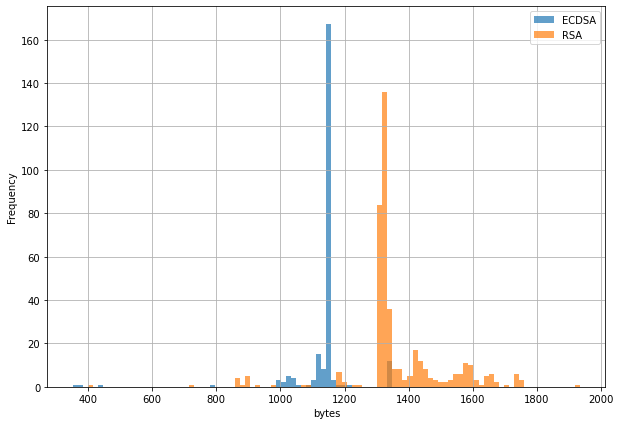

In [177]:
ax = build(certs_https, "public_key_algorithm").plot.hist(bins = 100, figsize = (10, 7), alpha = 0.7)
plt.grid()
ax.set_xlabel("bytes")
plt.savefig("figures/https_cert_sizes.pdf", bbox_inches='tight')

<br>
<br>
<br>
<br>

## Maps

#### Slowest UDP Resolvers

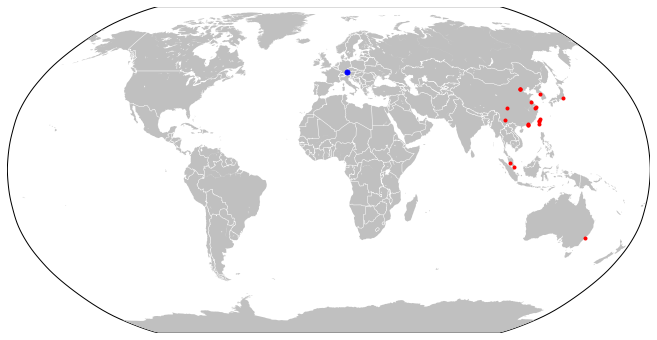

In [81]:
drawSlowestForProtocol("udp")

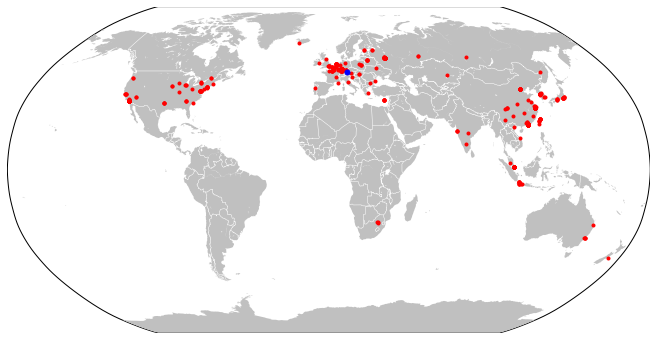

In [82]:
drawAllForProtocol("udp")

#### Slowest TCP Resolvers

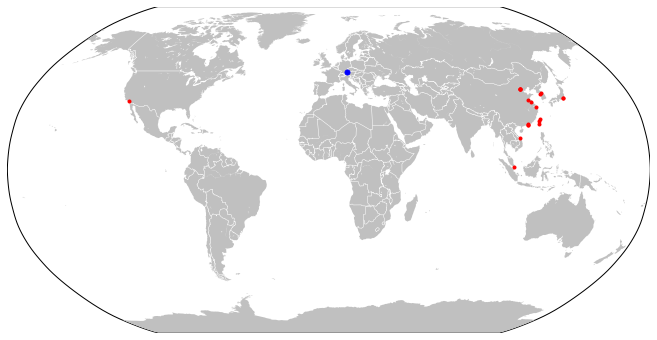

In [83]:
drawSlowestForProtocol("tcp")

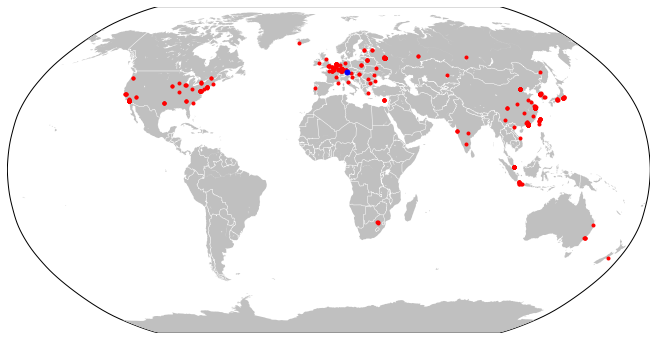

In [84]:
drawAllForProtocol("tcp")

#### Slowest TLS Resolvers

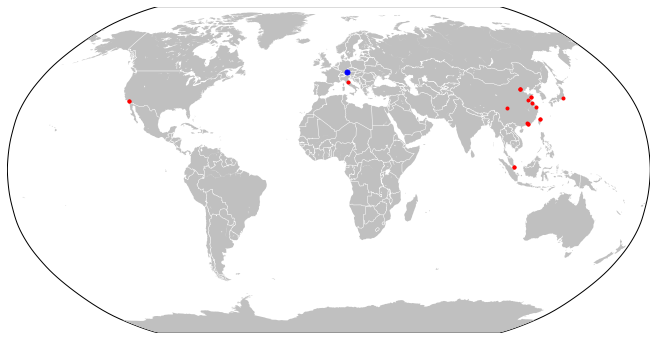

In [85]:
drawSlowestForProtocol("tls")

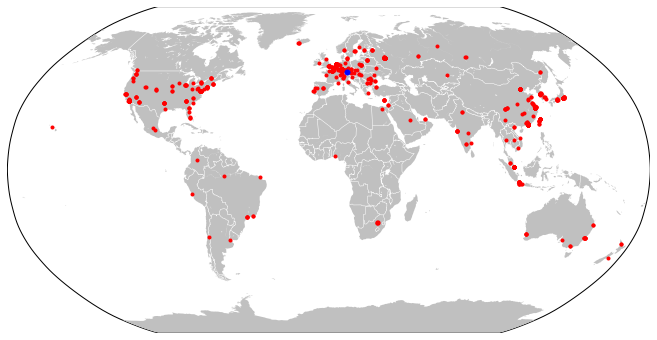

In [86]:
drawAllForProtocol("tls")

#### Slowest HTTPS Resolvers

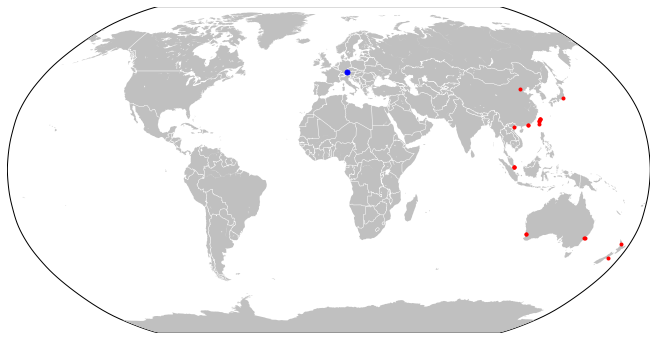

In [87]:
drawSlowestForProtocol("https")

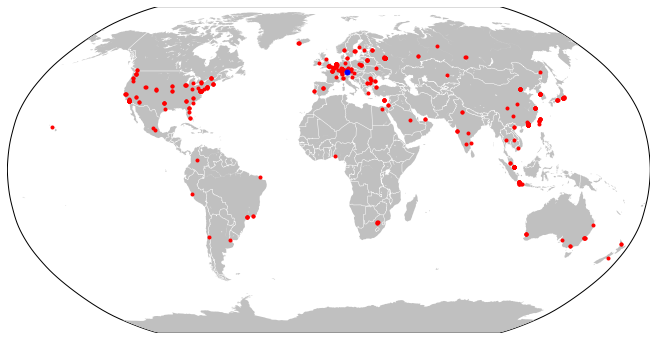

In [88]:
drawAllForProtocol("https")

<br>
<br>
<br>
<br>